In [1]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
path = "./results"


directory = os.fsencode(path)
df_full = None
    
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.find("mc_drop_gridseach_") != -1: 
            
            df = pd.read_csv(os.path.join(path, filename))
            
            if len(df) == 1:
                continue
                
            print(filename)
            if df_full is None:
                df_full = df
            else:
                df_full=  pd.concat([df_full, df])
                


mc_drop_gridseach_10_0.25_5800.csv
mc_drop_gridseach_20_0.5_3000.csv
mc_drop_gridseach_20_0.5_15.csv
mc_drop_gridseach_10_0.5_15.csv
mc_drop_gridseach_20_0.25_240.csv
mc_drop_gridseach_40_0.5_240.csv
mc_drop_gridseach_10_0.5_3000.csv
mc_drop_gridseach_40_0.5_15.csv
mc_drop_gridseach_10_0.5_240.csv
mc_drop_gridseach_10_0.25_15.csv
mc_drop_gridseach_20_0.5_240.csv
mc_drop_gridseach_10_0.25_240.csv
mc_drop_gridseach_40_0.25_3000.csv
mc_drop_gridseach_40_0.25_240.csv
mc_drop_gridseach_40_0.5_3000.csv
mc_drop_gridseach_20_0.25_15.csv
mc_drop_gridseach_20_0.25_3000.csv
mc_drop_gridseach_10_0.25_3000.csv
mc_drop_gridseach_40_0.25_15.csv


In [3]:
df_full.head()

,Unnamed: 0,num_mc_samples,dropout_prob,model_train_size,image_id,run_id,agg_uncertainty
0,0,10,0.25,5800,acdc_data3_20210722_pos_2_144,0,0.235820
1,1,10,0.25,5800,acdc_data3_20210722_pos_2_144,1,0.241860
2,2,10,0.25,5800,acdc_data3_20210722_pos_2_144,2,0.221014
3,3,10,0.25,5800,acdc_data3_20210722_pos_2_144,3,0.247020
4,4,10,0.25,5800,acdc_data3_20210722_pos_2_144,4,0.248857


In [4]:
exp_df = df_full[["num_mc_samples", "dropout_prob", "model_train_size", "image_id", "agg_uncertainty"]].groupby(by=["num_mc_samples", "dropout_prob", "model_train_size", "image_id"]).agg("var").reset_index().groupby(by=["model_train_size", "num_mc_samples", "dropout_prob"]).agg("mean").reset_index()
exp_df["mean_variances"] = exp_df["agg_uncertainty"]
exp_df

/tmp/ipykernel_780424/348318700.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  exp_df = df_full[["num_mc_samples", "dropout_prob", "model_train_size", "image_id", "agg_uncertainty"]].groupby(by=["num_mc_samples", "dropout_prob", "model_train_size", "image_id"]).agg("var").reset_index().groupby(by=["model_train_size", "num_mc_samples", "dropout_prob"]).agg("mean").reset_index()


,model_train_size,num_mc_samples,dropout_prob,agg_uncertainty,mean_variances
0,15,10,0.25,0.000833,0.000833
1,15,10,0.50,0.000791,0.000791
2,15,20,0.25,0.000734,0.000734
3,15,20,0.50,0.000765,0.000765
4,15,40,0.25,0.000693,0.000693
5,15,40,0.50,0.000615,0.000615
6,240,10,0.25,0.000247,0.000247
7,240,10,0.50,0.000412,0.000412
8,240,20,0.25,0.000139,0.000139
9,240,20,0.50,0.000343,0.000343


In [5]:
df_tmp = df_full[["num_mc_samples", "dropout_prob", "model_train_size", "image_id", "agg_uncertainty"]].groupby(by=["num_mc_samples", "dropout_prob", "model_train_size", "image_id"]).agg("mean").reset_index().groupby(by=["num_mc_samples", "dropout_prob", "model_train_size"]).agg("var").reset_index()
df_tmp["var_mean"] = df_tmp["agg_uncertainty"]
df_tmp
exp_df = pd.merge(exp_df, df_tmp, on=["num_mc_samples", "dropout_prob", "model_train_size"])

#.sort_values(by=["model_train_size", "agg_uncertainty"])



/tmp/ipykernel_780424/1495203603.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tmp = df_full[["num_mc_samples", "dropout_prob", "model_train_size", "image_id", "agg_uncertainty"]].groupby(by=["num_mc_samples", "dropout_prob", "model_train_size", "image_id"]).agg("mean").reset_index().groupby(by=["num_mc_samples", "dropout_prob", "model_train_size"]).agg("var").reset_index()


In [6]:

model_train_size = 15

def get_ap_df(model_train_size):
    with open(f"./results/maps_{model_train_size}.txt","r") as file:
        js_obj = json.load(file)

    records = [{"image_id":key, "segm_ap": js_obj[key]["segm"]["AP"] }for key in js_obj.keys()]
    df = pd.DataFrame.from_records(records)
    df["model_train_size"] = model_train_size
    
    return df

df_ap = None
for model_train_size in [15, 240, 3000, 5800]:
    df = get_ap_df(model_train_size)
    if df_ap is None:
        df_ap = df
    else:
        df_ap =  pd.concat([df_ap, df])
        
join_df = pd.merge(
    df_full,
    df_ap,
    how="inner",
    on=["model_train_size","image_id"])

join_df = join_df.groupby(by=["num_mc_samples", "dropout_prob", "model_train_size", "image_id"]).agg("mean").reset_index()
    

In [7]:
join_df["ap_scale"] = join_df["segm_ap"]/100

records = []

for num_mc_samples in join_df["num_mc_samples"].unique():
    
    for dropout_prob in join_df["dropout_prob"].unique():
        
            
        df_tmp = join_df[(join_df["num_mc_samples"] == num_mc_samples) & (join_df["dropout_prob"] == dropout_prob)]

        if df_tmp.empty:
            continue

        
        for model_train_size in join_df["model_train_size"].unique(): 
            
            df_reg = join_df[(join_df["num_mc_samples"] == num_mc_samples) & (join_df["dropout_prob"] == dropout_prob) & (join_df["model_train_size"] == model_train_size)].sort_values(by="agg_uncertainty").copy()
            
            
            if df_reg.empty:
                continue
           

            df_reg["norm_u"] = df_reg["agg_uncertainty"] # (df_reg["agg_uncertainty"]-df_reg["agg_uncertainty"].min())/(df_reg["agg_uncertainty"].max()-df_reg["agg_uncertainty"].min())
            df_reg["norm_ap"] = df_reg["ap_scale"] # (df_reg["ap_scale"]-df_reg["ap_scale"].min())/(df_reg["ap_scale"].max()-df_reg["ap_scale"].min())
            df_reg["dist"] = 1 / (df_reg["norm_ap"] + df_reg["norm_u"])
            df_reg_tmp = df_reg[df_reg["dist"] > 1]
            
            records.append({
                "num_mc_samples": num_mc_samples,
                "dropout_prob": dropout_prob,
                "model_train_size": model_train_size,
                "correlation": df_reg[["agg_uncertainty", "ap_scale"]].corr()["agg_uncertainty"]["ap_scale"],
                "l1_dist": df_reg_tmp["dist"].sum(),
            })
            
df_tmp = pd.DataFrame.from_records(records)
df_tmp.head()

,num_mc_samples,dropout_prob,model_train_size,correlation,l1_dist
0,10,0.25,15,0.104737,19.477551
1,10,0.25,240,-0.449412,62.816888
2,10,0.25,3000,-0.245686,63.183905
3,10,0.25,5800,-0.519518,24.972284
4,10,0.50,15,0.257837,4.406770


In [8]:
exp_df = pd.merge(exp_df, df_tmp, on=["num_mc_samples", "dropout_prob", "model_train_size"])

In [15]:
exp_df.groupby(by=["num_mc_samples"]).agg("mean").reset_index()

,num_mc_samples,model_train_size,dropout_prob,agg_uncertainty_x,mean_variances,agg_uncertainty_y,var_mean,correlation,l1_dist
0,10,1758.571429,0.357143,0.000427,0.000427,0.005576,0.005576,-0.220950,34.446244
1,20,1085.000000,0.375000,0.000385,0.000385,0.005329,0.005329,-0.201591,35.842528
2,40,1085.000000,0.375000,0.000340,0.000340,0.005073,0.005073,-0.189126,37.961782


In [14]:
exp_df.groupby(by=["dropout_prob"]).agg("mean").reset_index()

,dropout_prob,model_train_size,num_mc_samples,agg_uncertainty_x,mean_variances,agg_uncertainty_y,var_mean,correlation,l1_dist
0,0.25,1556.5,22.000000,0.000337,0.000337,0.005423,0.005423,-0.240468,46.455967
1,0.50,1085.0,23.333333,0.000441,0.000441,0.005247,0.005247,-0.165142,24.376656


In [19]:
exp_df.groupby(by=["dropout_prob", "model_train_size"]).agg("mean").reset_index().sort_values(by=["model_train_size","dropout_prob"])

,dropout_prob,model_train_size,num_mc_samples,agg_uncertainty_x,mean_variances,agg_uncertainty_y,var_mean,correlation,l1_dist
0,0.25,15,23.333333,0.000753,0.000753,0.004454,0.004454,0.080907,23.086713
4,0.50,15,23.333333,0.000724,0.000724,0.002761,0.002761,0.239856,8.629710
1,0.25,240,23.333333,0.000153,0.000153,0.006317,0.006317,-0.442004,62.038780
5,0.50,240,23.333333,0.000384,0.000384,0.006811,0.006811,-0.436028,26.138027
2,0.25,3000,23.333333,0.000127,0.000127,0.005894,0.005894,-0.267291,61.403636
6,0.50,3000,23.333333,0.000215,0.000215,0.006167,0.006167,-0.299252,38.362231
3,0.25,5800,10.000000,0.000268,0.000268,0.004233,0.004233,-0.519518,24.972284


10 0.25 5800
model_train_size 15 0.19677023834042745 correlation: 0.10473715764736104
19.47755126651408
model_train_size 240 -0.9763390447504725 correlation: -0.4494117203227196
62.816888210952385
model_train_size 3000 -0.4250922403679298 correlation: -0.24568634806325845
63.18390537720247
model_train_size 5800 -1.0401341835650795 correlation: -0.5195176862567666
24.97228385027117


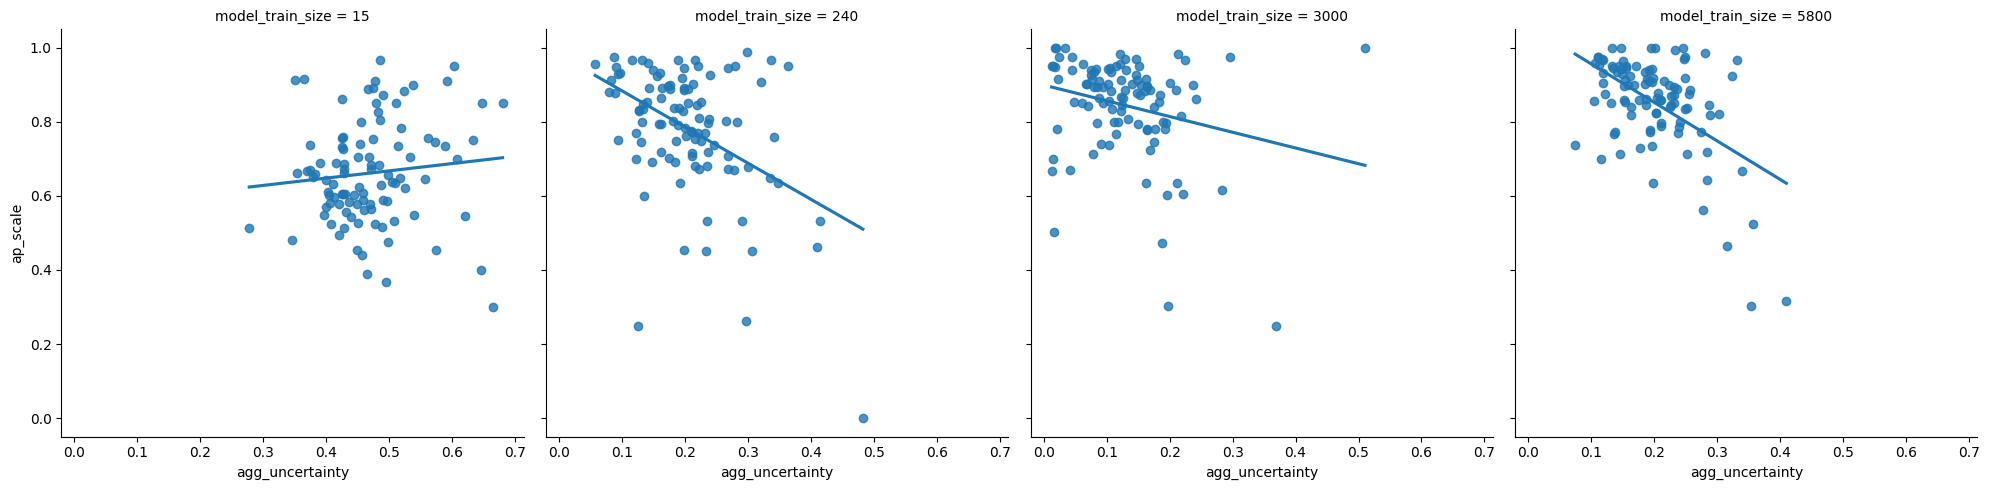

10 0.5 5800
model_train_size 15 0.5877478136317434 correlation: 0.2578366253207933
4.406770427564245
model_train_size 240 -0.8371235590479887 correlation: -0.41094131283996355
26.808225241283974
model_train_size 3000 -0.48728386153682063 correlation: -0.2836639648862023
39.45808488831436


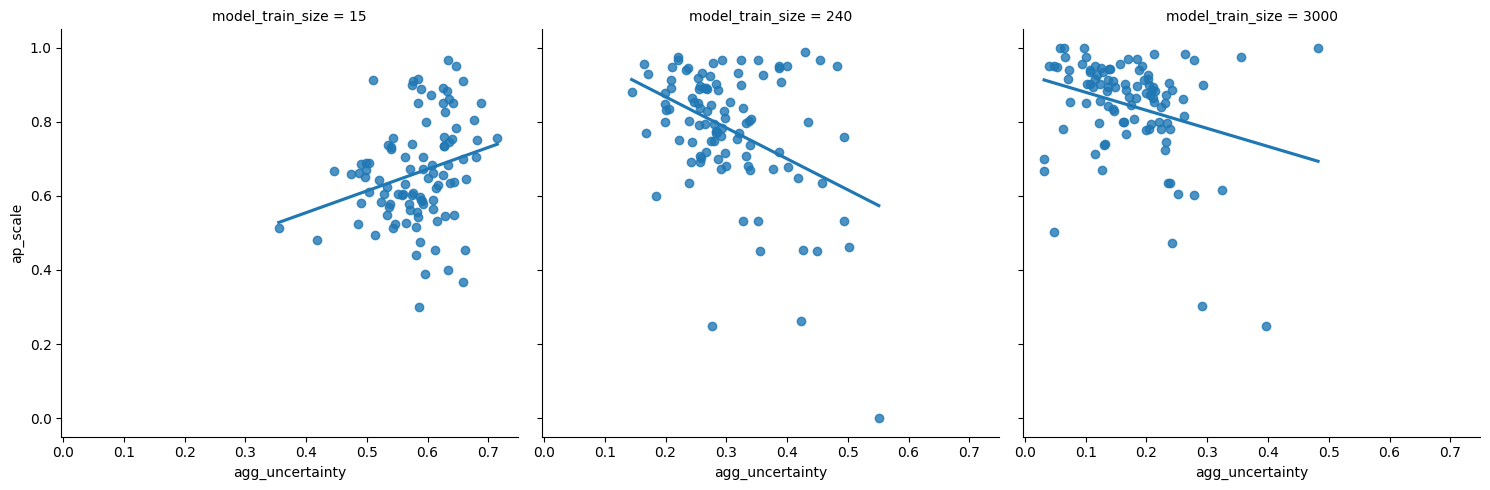

20 0.25 5800
model_train_size 15 0.1815076365080231 correlation: 0.08332024210963158
23.803770082331237
model_train_size 240 -0.9169741282771428 correlation: -0.4343069391745725
61.687135412201435
model_train_size 3000 -0.5162627594792366 correlation: -0.28629251811607237
60.016359623310535


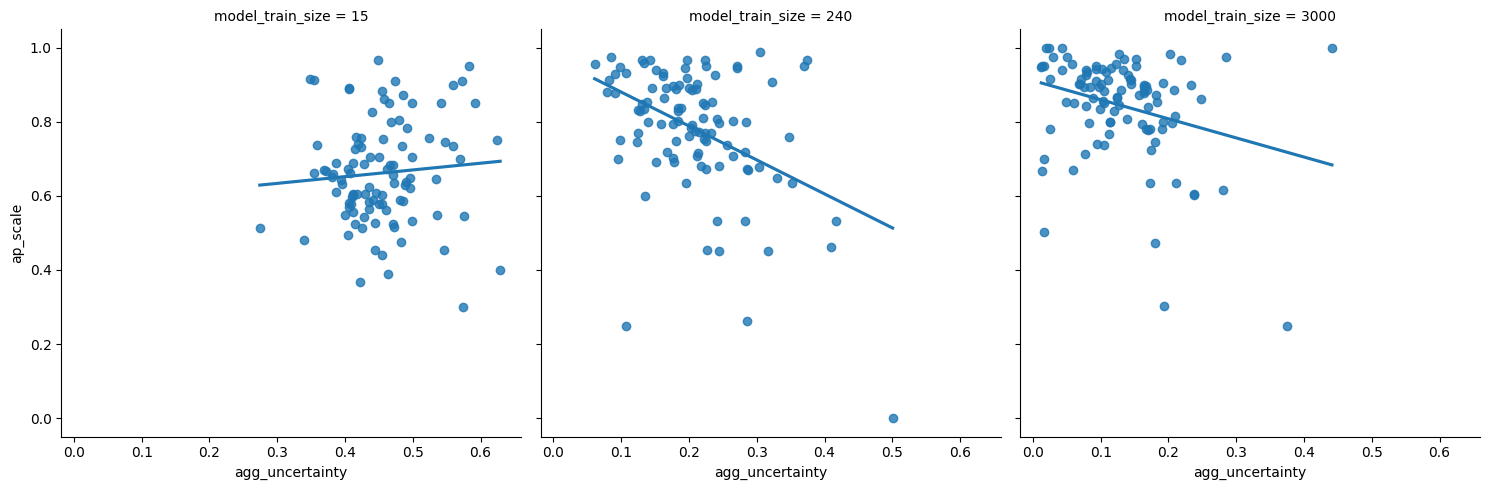

20 0.5 5800
model_train_size 15 0.5742043829528845 correlation: 0.2010591501339003
6.562671471758304
model_train_size 240 -0.9420408861046476 correlation: -0.46547146676062534
25.68793623888952
model_train_size 3000 -0.5284470133161184 correlation: -0.30785700324137183
37.29729671273094


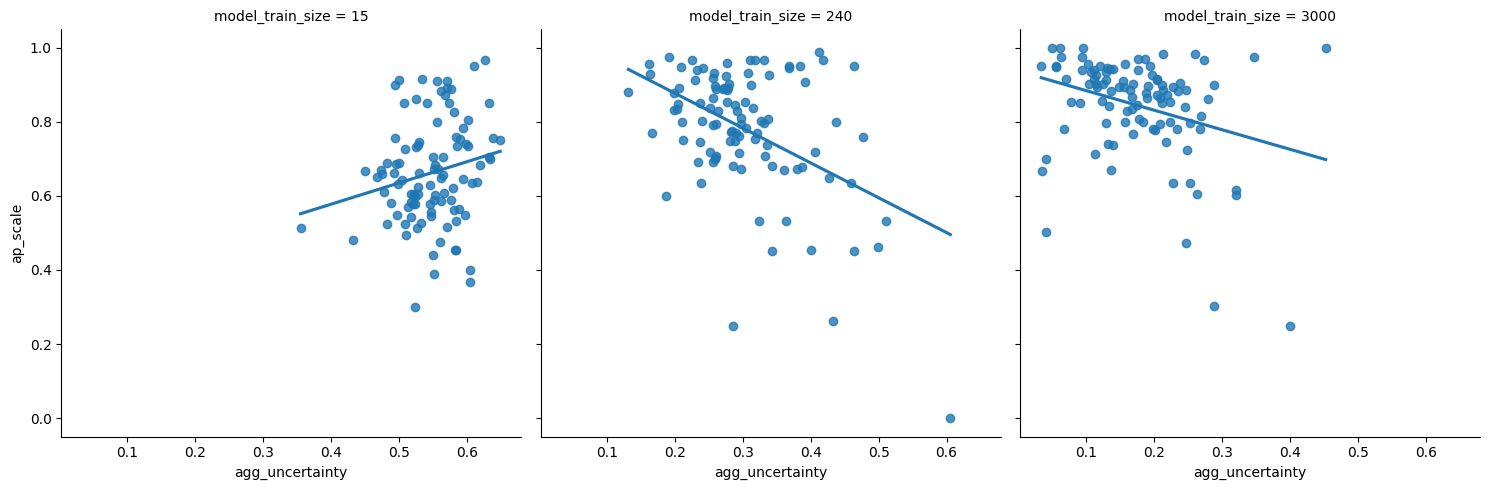

40 0.25 5800
model_train_size 15 0.1268946896059536 correlation: 0.0546638103123331
25.97881644146884
model_train_size 240 -0.9385334282732827 correlation: -0.4422923549993316
61.612317355457115
model_train_size 3000 -0.47929213744214094 correlation: -0.26989343309444114
61.01064200216777


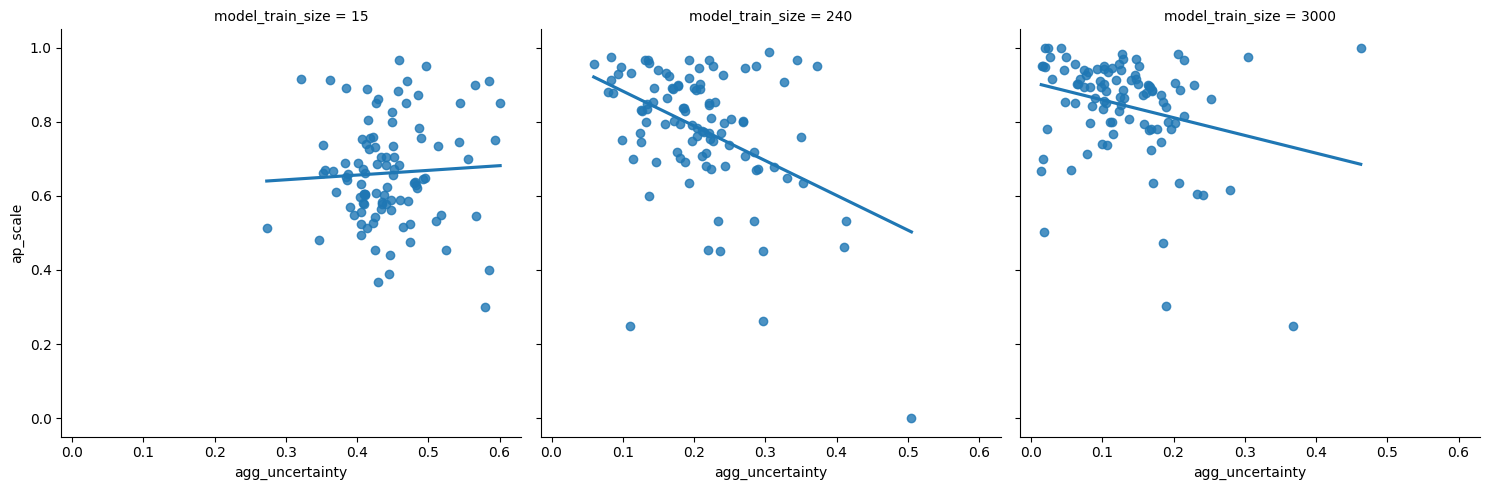

40 0.5 5800
model_train_size 15 0.7995160229563449 correlation: 0.2606710195765275
14.919687351745534
model_train_size 240 -0.9106606905357612 correlation: -0.43167120123743574
25.917920097763485
model_train_size 3000 -0.5372904342818577 correlation: -0.3062358858384642
38.33131120817089


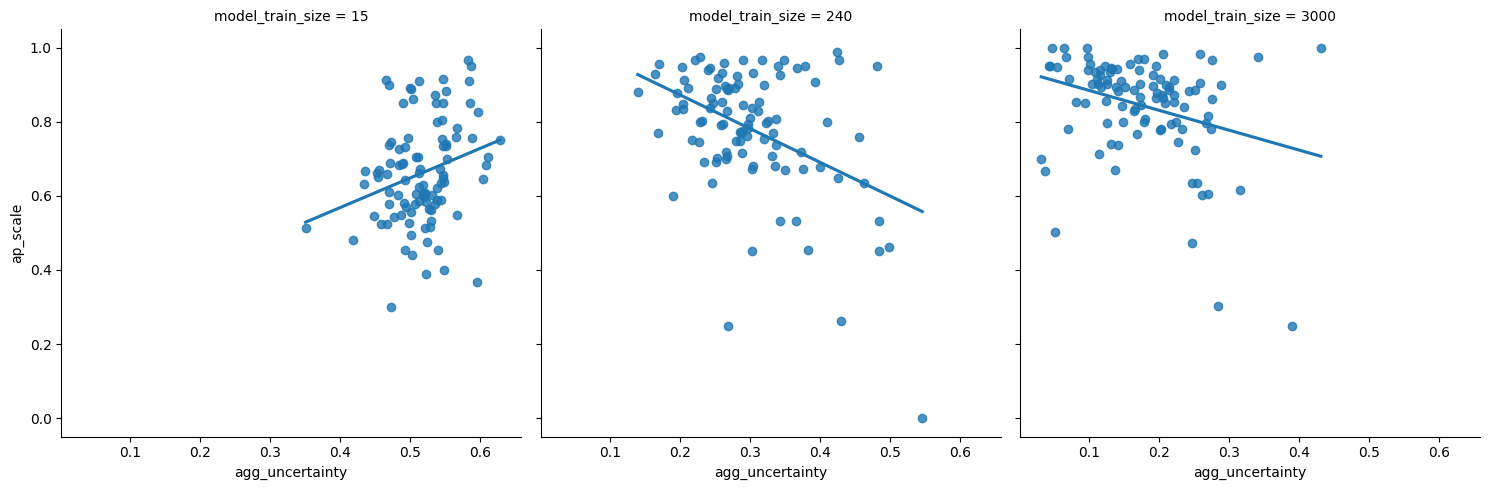

In [10]:
join_df["ap_scale"] = join_df["segm_ap"]/100


for num_mc_samples in join_df["num_mc_samples"].unique():
    
    for dropout_prob in join_df["dropout_prob"].unique():
        
            
        df_tmp = join_df[(join_df["num_mc_samples"] == num_mc_samples) & (join_df["dropout_prob"] == dropout_prob)]

        if df_tmp.empty:
            continue

        print(num_mc_samples, dropout_prob, model_train_size)
        
        for model_train_size in join_df["model_train_size"].unique(): 
            
            df_reg = join_df[(join_df["num_mc_samples"] == num_mc_samples) & (join_df["dropout_prob"] == dropout_prob) & (join_df["model_train_size"] == model_train_size)].sort_values(by="agg_uncertainty").copy()
            
            
            if df_reg.empty:
                continue
           
            X = df_reg["agg_uncertainty"].values.reshape(-1, 1)  # values converts it into a numpy array
            Y = df_reg["ap_scale"].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
            linear_regressor = LinearRegression()  # create object for the class
            linear_regressor.fit(X, Y)  # perform linear regression
            print("model_train_size", model_train_size, linear_regressor.coef_[0][0], "correlation:", df_reg[["agg_uncertainty", "ap_scale"]].corr()["agg_uncertainty"]["ap_scale"])
            df_reg["norm_u"] = df_reg["agg_uncertainty"] # (df_reg["agg_uncertainty"]-df_reg["agg_uncertainty"].min())/(df_reg["agg_uncertainty"].max()-df_reg["agg_uncertainty"].min())
            df_reg["norm_ap"] = df_reg["ap_scale"] # (df_reg["ap_scale"]-df_reg["ap_scale"].min())/(df_reg["ap_scale"].max()-df_reg["ap_scale"].min())
            df_reg["dist"] = 1 / (df_reg["norm_ap"] + df_reg["norm_u"])
            df_reg = df_reg[df_reg["dist"] > 1]
            
            
            print(df_reg["dist"].sum())

        sns.lmplot(data=df_tmp, x="agg_uncertainty", y="ap_scale", ci=None, col='model_train_size')
        plt.show()

<AxesSubplot: xlabel='agg_uncertainty', ylabel='segm_ap'>

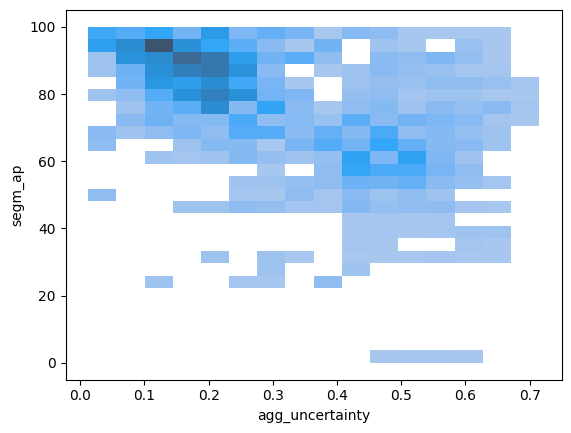

In [11]:
sns.histplot(data=join_df, x="agg_uncertainty", y="segm_ap")

10 0.25 15


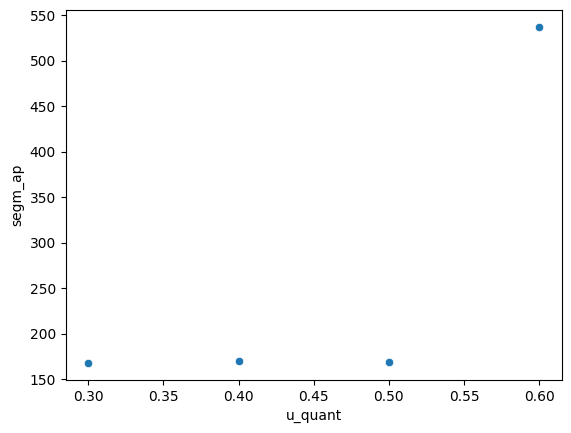

10 0.25 240


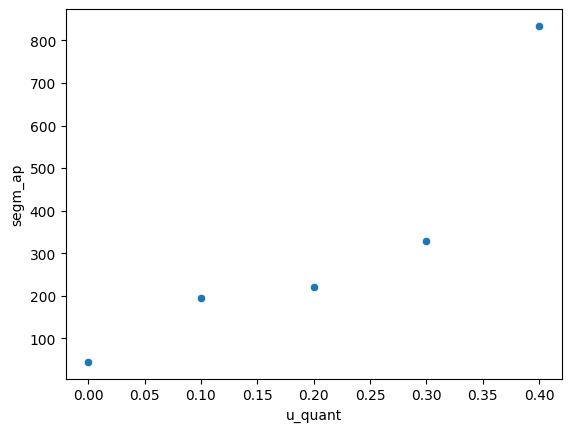

10 0.25 3000


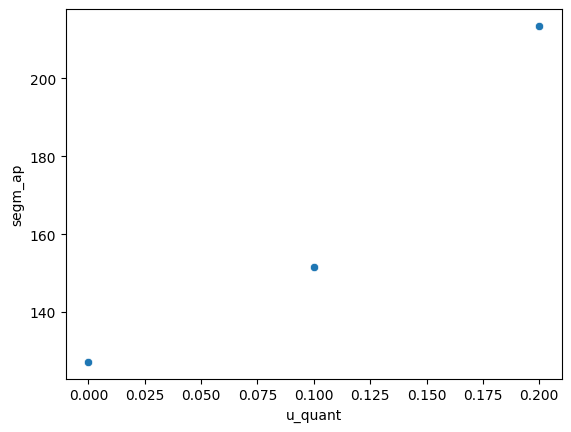

10 0.25 5800


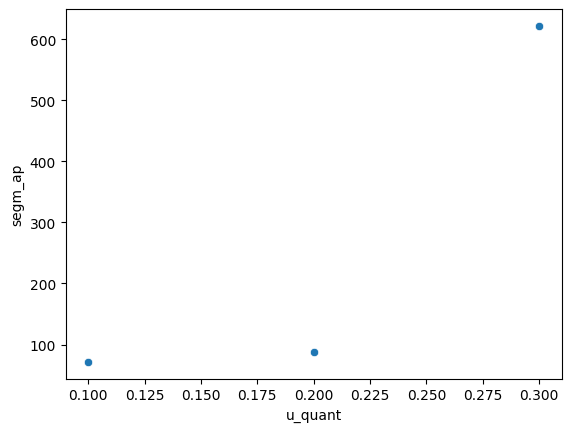

10 0.5 15


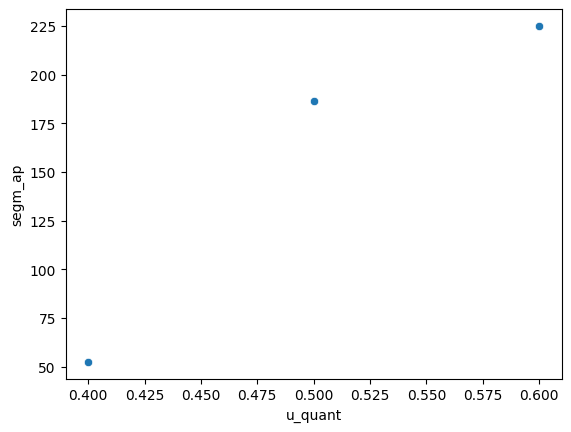

10 0.5 240


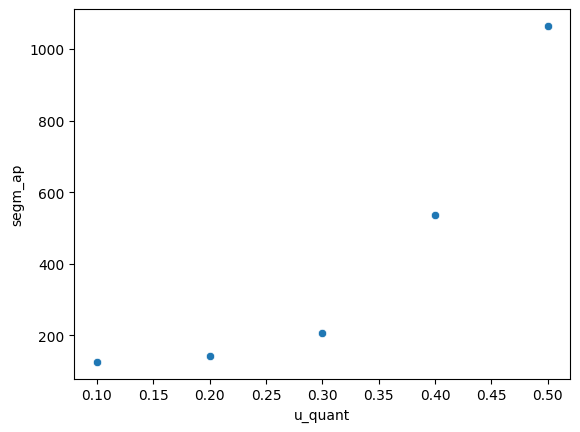

10 0.5 3000


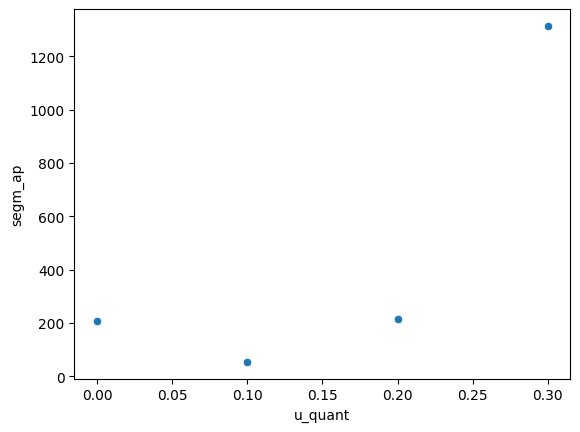

20 0.25 15


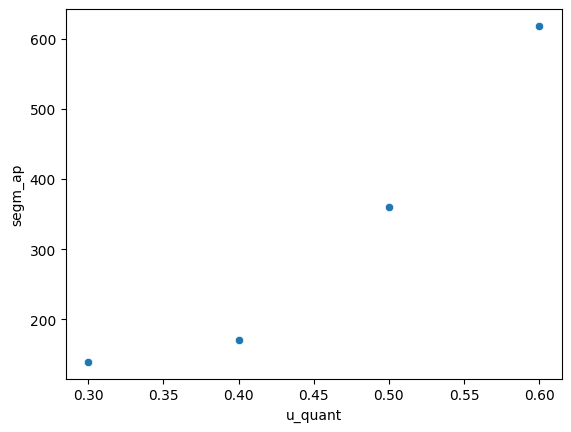

20 0.25 240


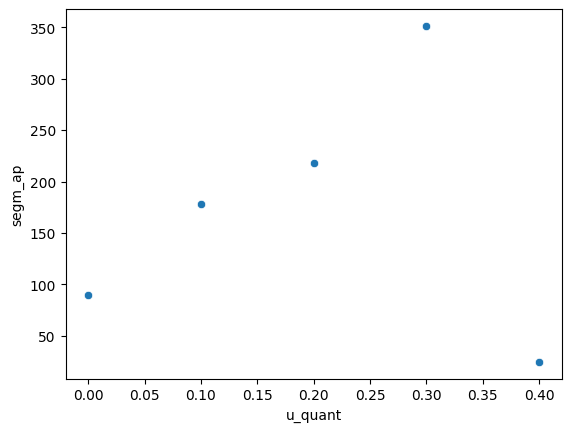

20 0.25 3000


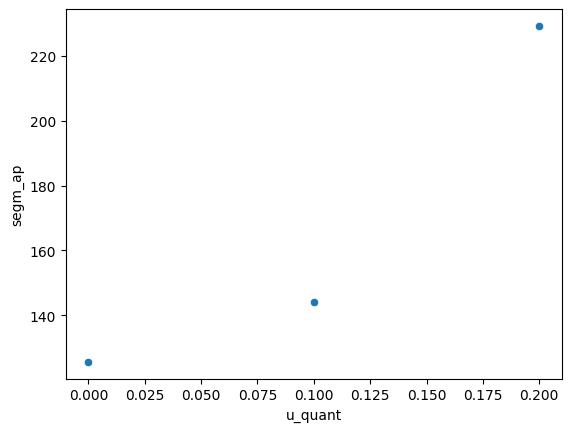

20 0.5 15


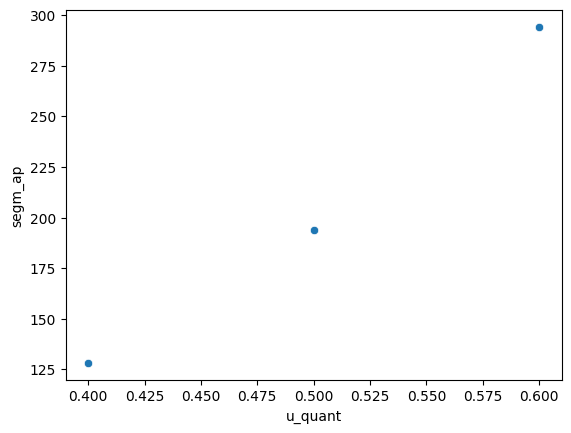

20 0.5 240


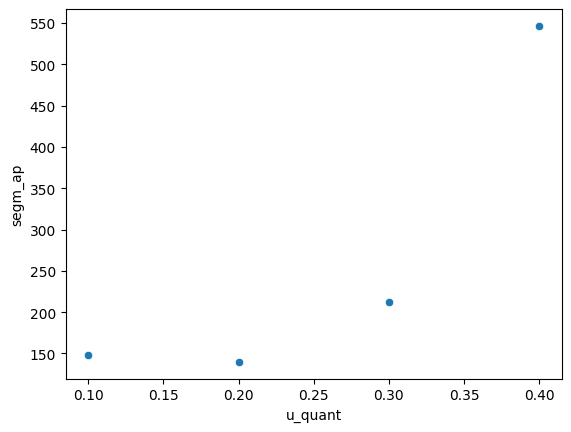

20 0.5 3000


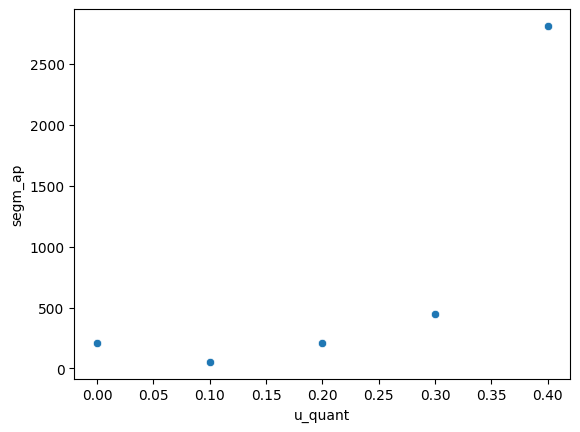

40 0.25 15


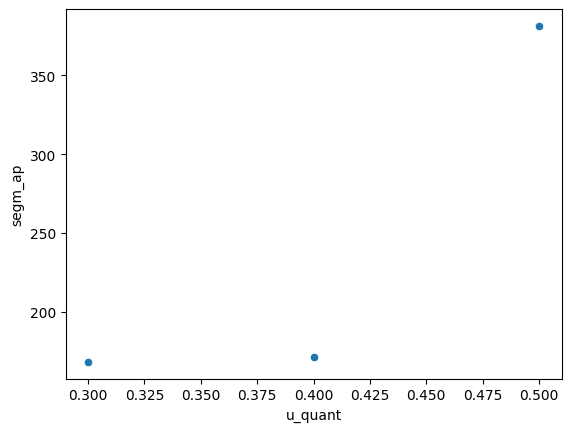

40 0.25 240


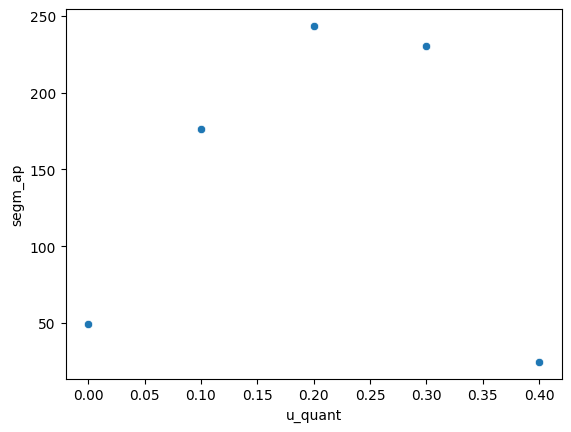

40 0.25 3000


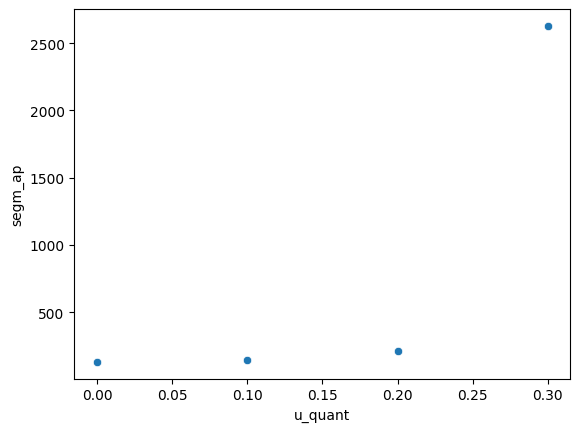

40 0.5 15


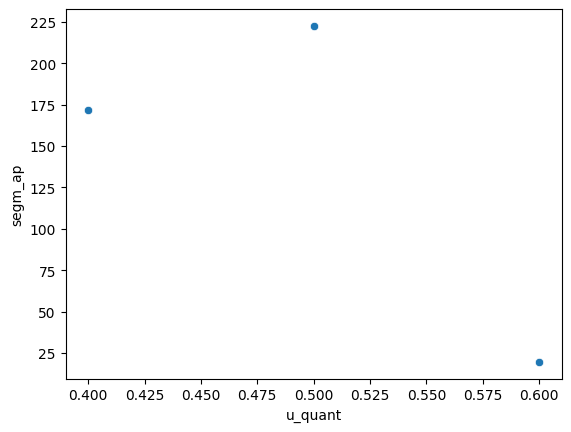

40 0.5 240


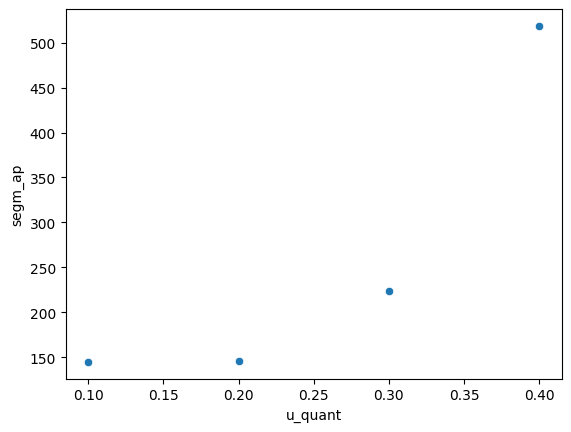

40 0.5 3000


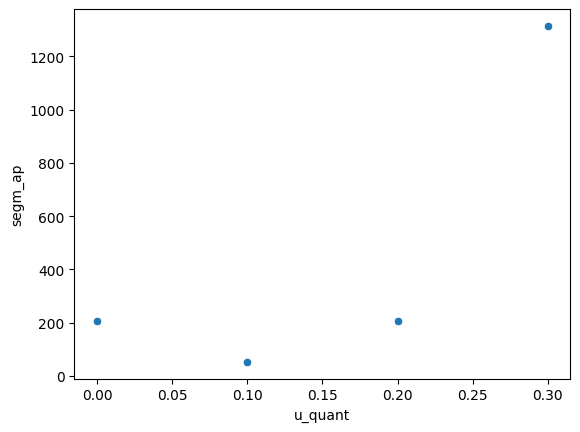

In [12]:
for num_mc_samples in join_df["num_mc_samples"].unique():
    
    for dropout_prob in join_df["dropout_prob"].unique():
        for model_train_size in join_df["model_train_size"].unique():
            
            
            df_tmp = join_df[(join_df["num_mc_samples"] == num_mc_samples) & (join_df["dropout_prob"] == dropout_prob) & (join_df["model_train_size"] == model_train_size)]
            if not df_tmp.empty:
                join_df_new = df_tmp.copy()


                join_df_new['u_quant'] = (join_df_new['agg_uncertainty'] * 10).astype("int") / 10
                
                
                test_df = join_df_new[["u_quant","segm_ap"]].groupby(by=["u_quant"]).agg("var").reset_index()
                test_df
                print(num_mc_samples, dropout_prob, model_train_size)
                sns.scatterplot(data=test_df, x="u_quant", y="segm_ap")
                plt.show()